# Debugging
Inspecting the output of `compute-sanitizer --tool memcheck lab6/transpose > memcheck.out`, we observe a lot of similar errors of the form:
```
========= Invalid __global__ read of size 4 bytes
=========     at 0x2d0 in /workspaces/HPC/lab6/transpose.cu:15:transpose(float *, const float *)
=========     by thread (0,0,0) in block (3,8,0)
=========     Address 0x7f5f5e000180 is out of bounds
```
This is always for threads where `blockIdx.y == 8`.

For sake of exrecise let's launch `cuda-gdb`. We get:
```
break transpose if blockIdx.y == 8
step
```
We get that :
```
(cuda-gdb) print (blockDim.x * blockIdx.y * 32 + threadIdx.y)* (gridDim.x*32) + x
$4 = 67109952
```
But we know that the input array size is $8192^2 = 67108864$. So that makes sense.

We would expect the calls to the matrxi to be symmetric in x and y. Indeed, if we switch:
```
int x = blockIdx.x * TILE_DIM + threadIdx.x;
int y = blockDim.x * blockIdx.y * TILE_DIM + threadIdx.y;
```
to
```
int x = blockIdx.x * TILE_DIM + threadIdx.x;
int y = blockIdx.y * TILE_DIM + threadIdx.y;
```
We see that if we take the bounds on these coords we get the desired array locations.

In [21]:
! nvcc -g -G transpose.cu -o transpose

In [22]:
! compute-sanitizer --tool memcheck ./transpose > memcheck.out

In [23]:
! nvcc -g -G transpose_corrected.cu -o transpose_corrected

In [24]:
! ./transpose_corrected

Time to generate: 32.4 ms
All good


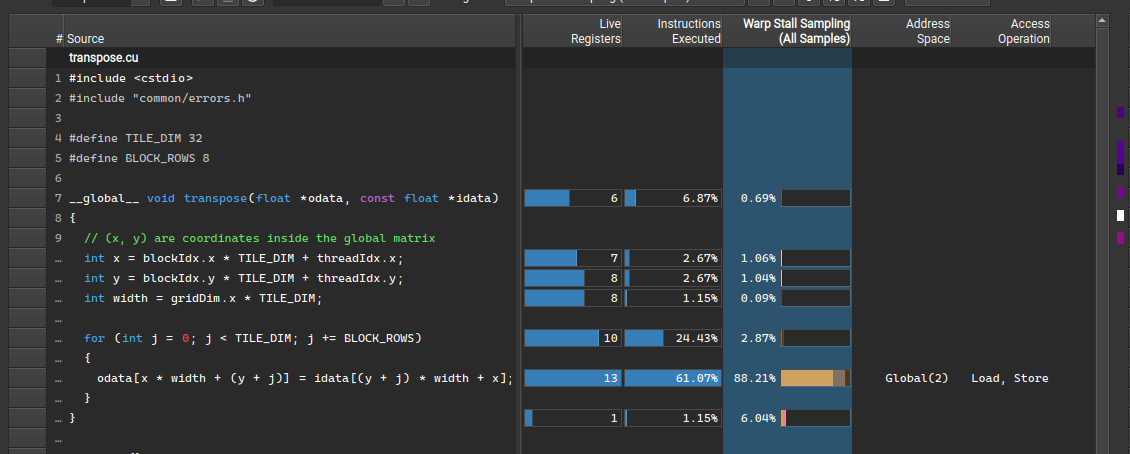

In [25]:
from IPython.display import Image
Image(filename='warp_stall.png')
 

We can observe warp stall sampling on the memory transfer. This is because of the strided access on the write (the x's are next to each other on the read).https://docs.nvidia.com/cuda/cuda-c-best-practices-guide/#strided-accesses.

The profiling below was done from data obtained on the entropy cluster.

So we use shared memory for every block to write to. I.e. replace:
```
__global__ void transpose(float *odata, const float *idata)
{
  // (x, y) are coordinates inside the global matrix
  int x = blockIdx.x * TILE_DIM + threadIdx.x;
  int y = blockIdx.y * TILE_DIM + threadIdx.y;
  int width = gridDim.x * TILE_DIM;

  for (int j = 0; j < TILE_DIM; j += BLOCK_ROWS)
  {
    odata[x * width + (y + j)] = idata[(y + j) * width + x];
  }
}
```
with:
```
__global__ void transpose(float *odata, const float *idata)
{
    // (x, y) are coordinates inside the global matrix
    int x = blockIdx.x * TILE_DIM + threadIdx.x;
    int y = blockIdx.y * TILE_DIM + threadIdx.y;
    int width = gridDim.x * TILE_DIM;

    __shared__ float temp_tile[TILE_DIM][TILE_DIM + 1];

    for (int j = 0; j < TILE_DIM; j += BLOCK_ROWS)
    {
        temp_tile[threadIdx.x][threadIdx.y + j] = idata[(y + j) * width + x];
    }

    __syncthreads();
    x = blockIdx.y * TILE_DIM + threadIdx.x;
    y = blockIdx.x * TILE_DIM + threadIdx.y;
    for (int j = 0; j < TILE_DIM; j += BLOCK_ROWS)
    {
        odata[(y + j) * width + x] = temp_tile[threadIdx.y + j][threadIdx.x];
    }
}
```

We have `__shared__ int temp_tile[TILE_DIM][TILE_DIM + 1];` instead of `__shared__ int temp_tile[TILE_DIM][TILE_DIM];` because of https://docs.nvidia.com/cuda/cuda-c-best-practices-guide/#shared-memory-in-matrix-multiplication-c-aat suggesting this avoids the strided access in local mem.

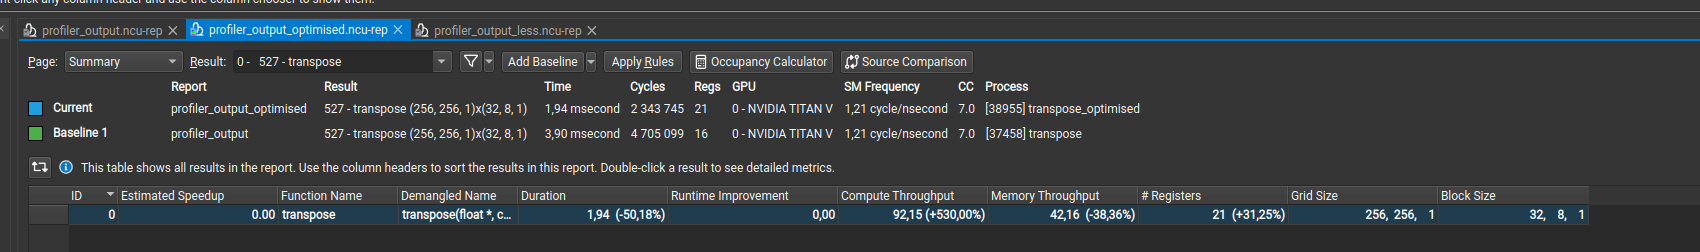

In [26]:
from IPython.display import Image
Image(filename='opt.png')

We see that we have a large speedup with all optimsations, but also use quite a bit more memory. However:

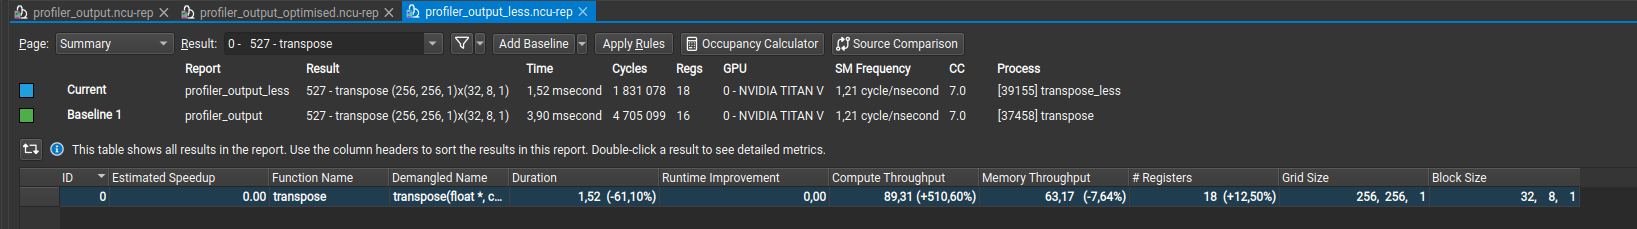

In [27]:
from IPython.display import Image
Image(filename='opt_less.png')

So we see that is we do `__shared__ int temp_tile[TILE_DIM][TILE_DIM];` instead of `__shared__ int temp_tile[TILE_DIM][TILE_DIM+1];` afterall, the speedup isn't much less, at the same time using memory comparable to unoptimised kernel.